In [1]:
import sys
sys.path.append('../')

from tqdm import tqdm

import torch as tc
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from rcgp.experimental import SpatioTemporalRCGP

from data.simulations import spatio_temporal_half_contaminated

In [2]:
ts, grids, Ys, true_Ys, Ys_no_outliers, outliers_loc, n_lon, n_lat, lon_norm, lat_norm = spatio_temporal_half_contaminated()

In [3]:
def plot(idx, grid, ts, pred, Ys, Ys_no_outliers, outliers_loc, true_Ys, n_lon, n_lat):

    x,y = grid[:, 0], grid[:, 1]
    X = x.reshape(n_lon, n_lat)
    Y = y.reshape(n_lon, n_lat)
    
    pred = pred[idx].reshape(n_lon, n_lat)
    Ys = Ys[idx].reshape(n_lon, n_lat)
    Ys_no_outliers = Ys_no_outliers[idx].reshape(n_lon, n_lat)
    true_Ys = true_Ys[idx].reshape(n_lon, n_lat)


    fig, axs = plt.subplots(1, 3, figsize=(12,3))
    kwargs = {"levels" : 10, "cmap": "YlGnBu"}

    outliers_loc_t = outliers_loc[np.where(np.isclose(outliers_loc[:, 0], ts[idx]))]

    axs[0].contourf(X, Y, pred, **kwargs)
    axs[1].contourf(X, Y, Ys_no_outliers, **kwargs)
    axs[1].scatter(outliers_loc_t[:, 1], outliers_loc_t[:, 2], marker='.', s=30., color='red')
    axs[2].contourf(X, Y, true_Ys, **kwargs)
    
    axs[0].set_title("Prediction")
    axs[1].set_title("Data")
    axs[2].set_title("True Latent Function")

    print("Mean Absolute Difference (Data - No Outliers) : ", np.abs(Ys_no_outliers - true_Ys).sum().item())
    print("Mean Absolute Difference (Prediction) : ", np.abs(pred - true_Ys).sum().item())

    return

In [4]:
def scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):
    S = covs + R
    eps = Ys - preds

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)
    Ws = (Ws / Ws.sum()).squeeze()
    
    return energies.sum()

100%|██████████| 12/12 [00:23<00:00,  1.99s/it]


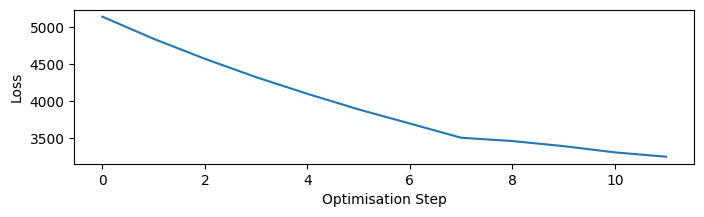

In [ ]:
strcgp = SpatioTemporalRCGP(ts=ts, grid=grids[0], Ys=Ys, p=1)
#strcgp.activate_robustness(func="constant") 

strcgp.activate_robustness(func="local_constant") 
strcgp._K_w_lengthscale = 1.

strcgp.adaptive_c()

#SUPER INTERESTING: WHEN DEACTIVATING ROBUSTNESS AND USING TRUE_FUNC, STILL CAN'T RECOVER TRUE FUNCTION WELL -> need for robustness. Scoring rule is separate issue
strcgp.deactivate_robustness()

losses = []
n_steps = 12
lr = 0.2

optimizer = tc.optim.Adam(strcgp.parameters(), lr=lr)

for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = strcgp.forward(m0_data=True)
    #loss = scoring_rule(Ys=Ys, preds=preds, covs=covs, R=R, Ws=Ws)
    loss = tc.abs(preds - true_Ys).sum()
    loss.backward()
    losses.append(loss.clone().detach())
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [59]:
print("---Likelihood Variance----")
print(strcgp.var_y.clone().detach())
print("\n----Temporal Lengthscale, Magnitude----")
print(strcgp.spatial_lengthscale.clone().detach(), strcgp.spatial_magnitude.clone().detach())
print("\n----Spatial Lengthscale, Magnitude-----")
print(strcgp.temporal_lengthscale.clone().detach(), strcgp.temporal_magnitude.clone().detach())

---Likelihood Variance----
tensor(0.3906)

----Temporal Lengthscale, Magnitude----
tensor(1.9658) tensor(2.2788)

----Spatial Lengthscale, Magnitude-----
tensor(0.3662) tensor(2.2655)


Mean Absolute Difference (Data - No Outliers) :  101.3565444946289
Mean Absolute Difference (Prediction) :  102.36751556396484
Mean Absolute Difference (Data - No Outliers) :  97.08243560791016
Mean Absolute Difference (Prediction) :  100.03974151611328
Mean Absolute Difference (Data - No Outliers) :  98.51832580566406
Mean Absolute Difference (Prediction) :  120.8871841430664
Mean Absolute Difference (Data - No Outliers) :  100.95301818847656
Mean Absolute Difference (Prediction) :  111.69105529785156
Mean Absolute Difference (Data - No Outliers) :  93.23451232910156
Mean Absolute Difference (Prediction) :  111.04817962646484
Mean Absolute Difference (Data - No Outliers) :  97.20365142822266
Mean Absolute Difference (Prediction) :  98.32388305664062
Mean Absolute Difference (Data - No Outliers) :  100.76924896240234
Mean Absolute Difference (Prediction) :  106.29463958740234
Mean Absolute Difference (Data - No Outliers) :  98.46554565429688
Mean Absolute Difference (Prediction) :  110

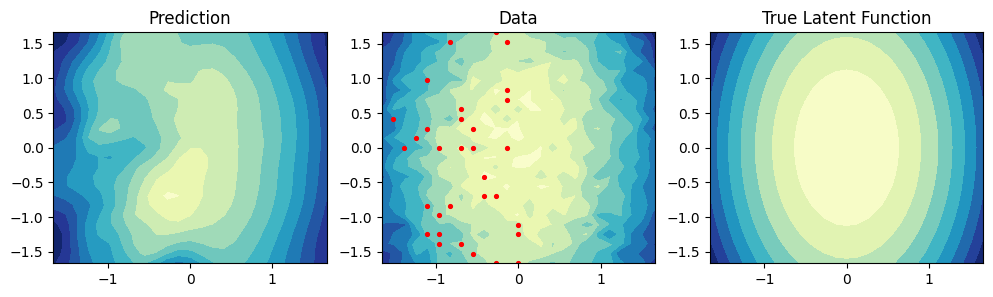

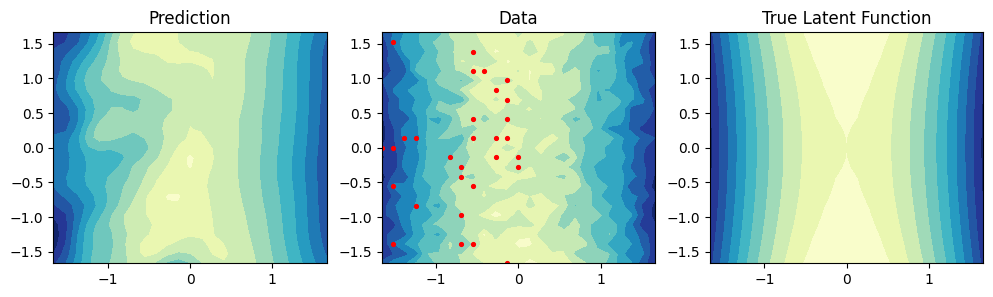

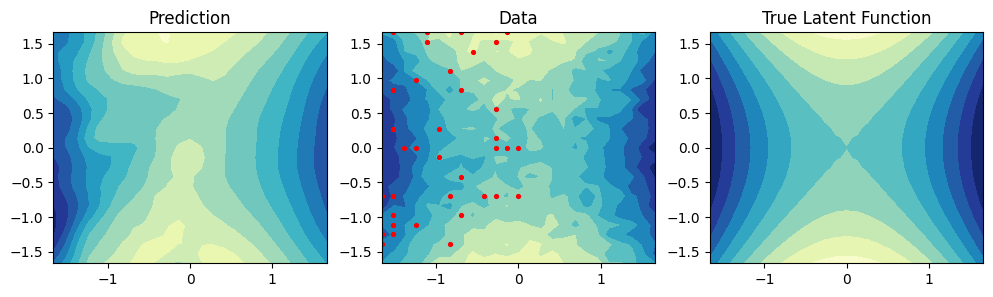

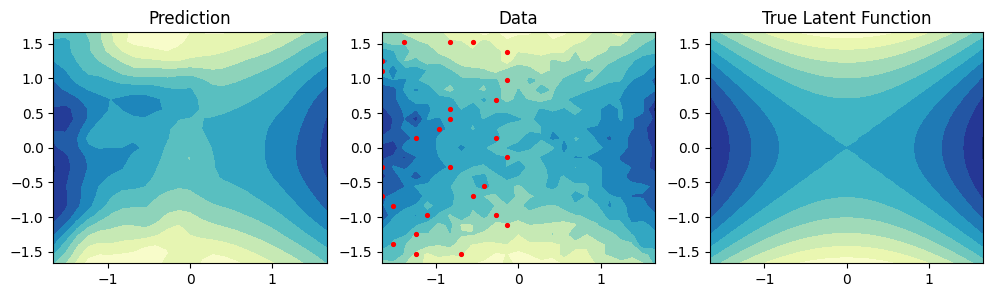

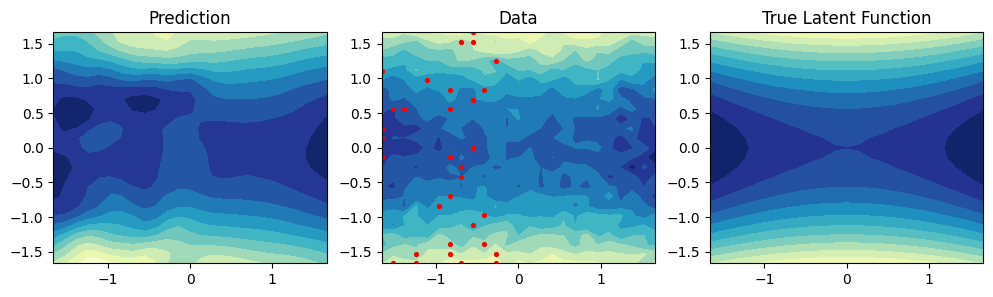

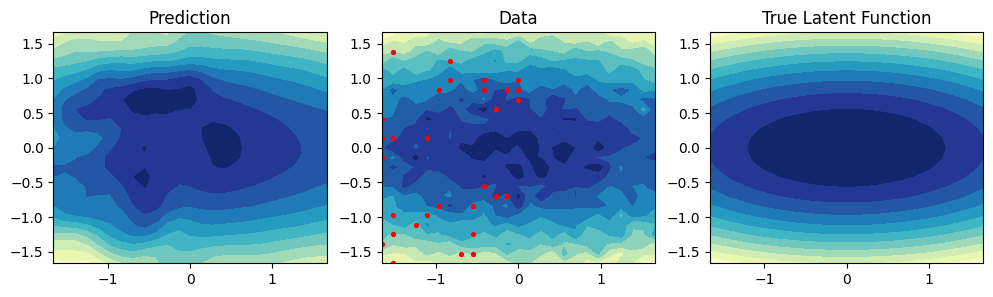

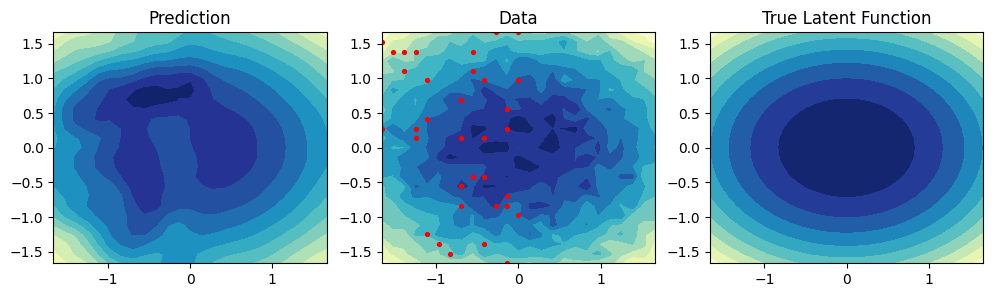

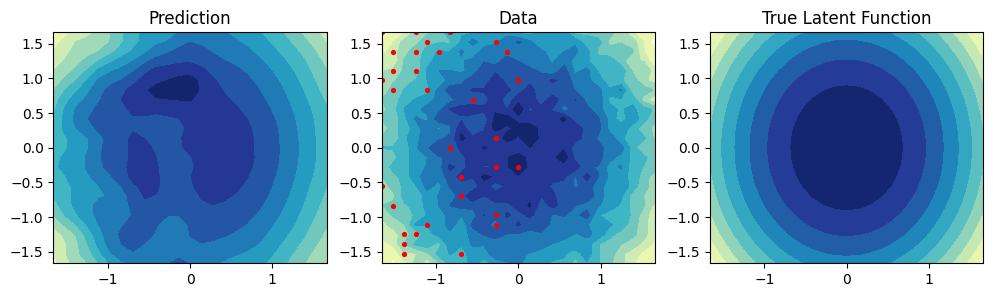

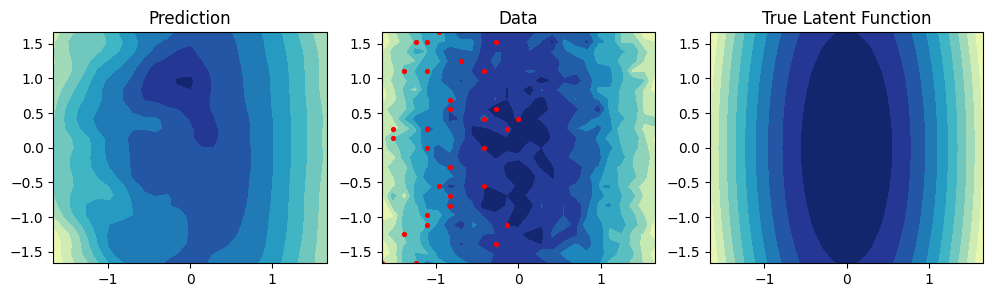

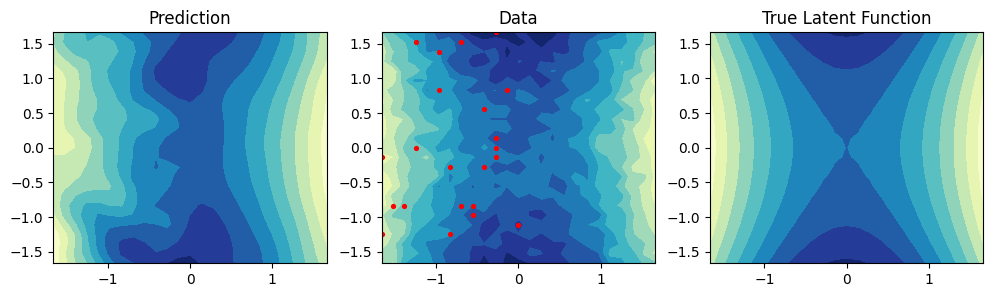

In [60]:
with tc.no_grad():
    (pred_strcgp, std_strcgp, strcgp_eff), _, _ = strcgp.forward()


for i in range(10):
     plot(idx=i, grid=grids[0], ts=ts, pred=pred_strcgp, Ys=Ys, Ys_no_outliers=Ys_no_outliers, outliers_loc=outliers_loc, true_Ys=true_Ys, n_lon=n_lon, n_lat=n_lat)

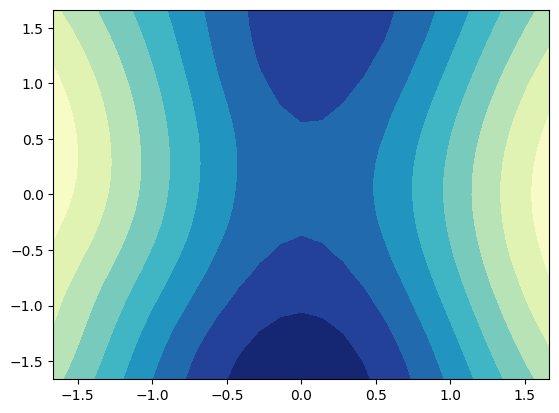

In [57]:
t_idx = 9
plt.contourf(grids[0][:, 0].reshape(n_lon, n_lat), grids[0][:, 1].reshape(n_lon, n_lat), (strcgp.K_w @ Ys[t_idx]).reshape(n_lon, n_lat), **{"levels" : 10, "cmap": "YlGnBu"})
del t_idx

In [27]:
def plot_robust_func(func):
    strcgp = SpatioTemporalRCGP(ts=ts, Ys=Ys, grid=grids[0], p=1)
    strcgp.activate_robustness(func=func)
    strcgp.beta = 0.6
    strcgp.c = 4.
    strcgp.temporal_lengthscale = 0.4
    strcgp.spatial_lengthscale = 0.8
    strcgp.var_y = 1

    with tc.no_grad():
        (pred_strcgp, std_strcgp, strcgp_eff), _, _ = strcgp.forward()

    for i in range(8):
        plot(idx=i, grid=grids[0], ts=ts, pred=pred_strcgp, Ys=Ys, Ys_no_outliers=Ys_no_outliers, outliers_loc=outliers_loc, true_Ys=true_Ys, n_lon=n_lon, n_lat=n_lat)


Mean Absolute Difference (Data - No Outliers) :  101.3565444946289
Mean Absolute Difference (Prediction) :  191.7455291748047
Mean Absolute Difference (Data - No Outliers) :  97.08243560791016
Mean Absolute Difference (Prediction) :  72.76332092285156
Mean Absolute Difference (Data - No Outliers) :  98.51832580566406
Mean Absolute Difference (Prediction) :  57.45392990112305
Mean Absolute Difference (Data - No Outliers) :  100.95301818847656
Mean Absolute Difference (Prediction) :  82.85568237304688
Mean Absolute Difference (Data - No Outliers) :  93.23451232910156
Mean Absolute Difference (Prediction) :  62.75706481933594
Mean Absolute Difference (Data - No Outliers) :  97.20365142822266
Mean Absolute Difference (Prediction) :  63.910797119140625
Mean Absolute Difference (Data - No Outliers) :  100.76924896240234
Mean Absolute Difference (Prediction) :  54.926082611083984
Mean Absolute Difference (Data - No Outliers) :  98.46554565429688
Mean Absolute Difference (Prediction) :  52.695

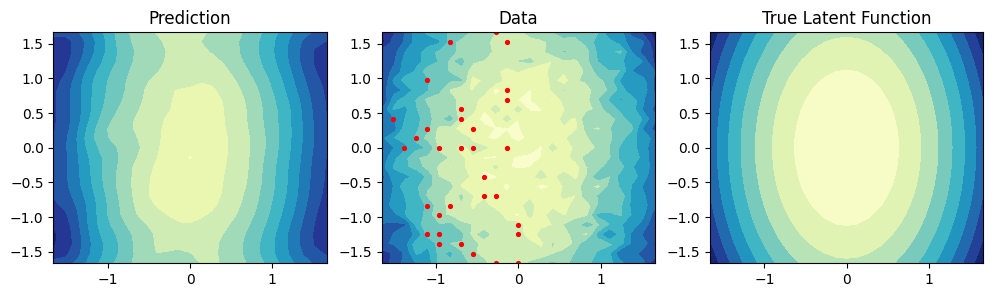

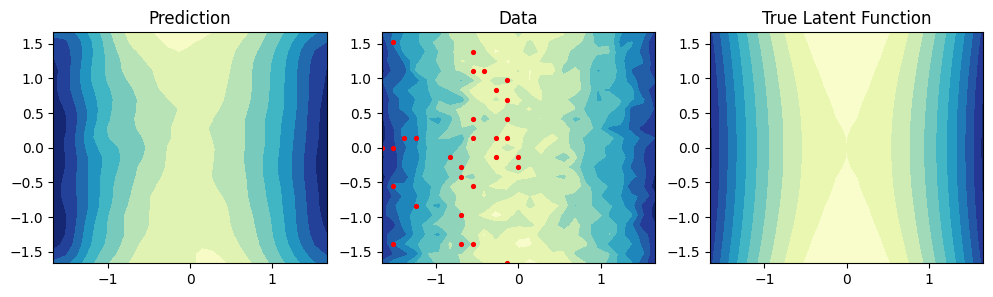

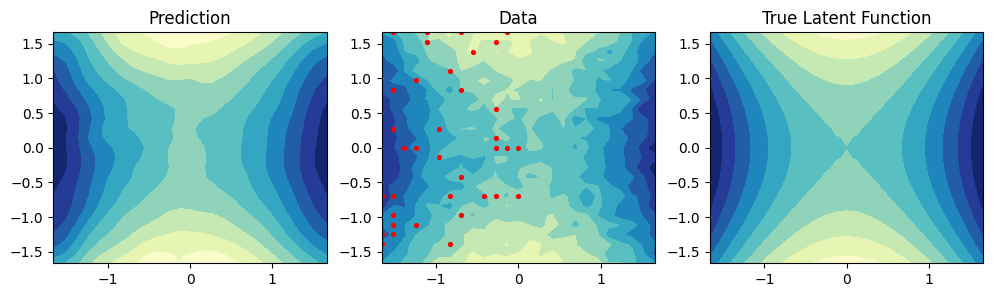

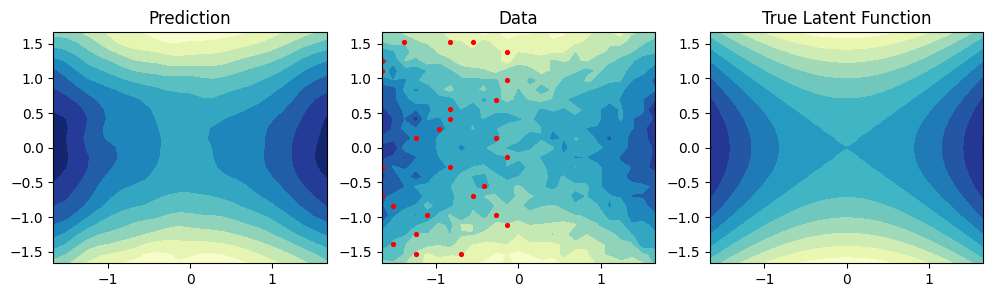

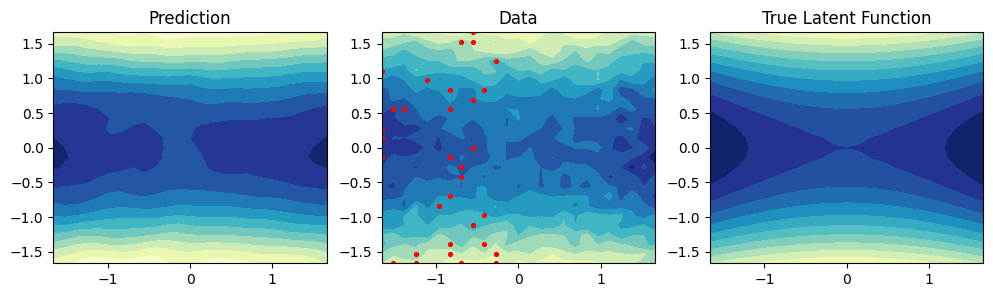

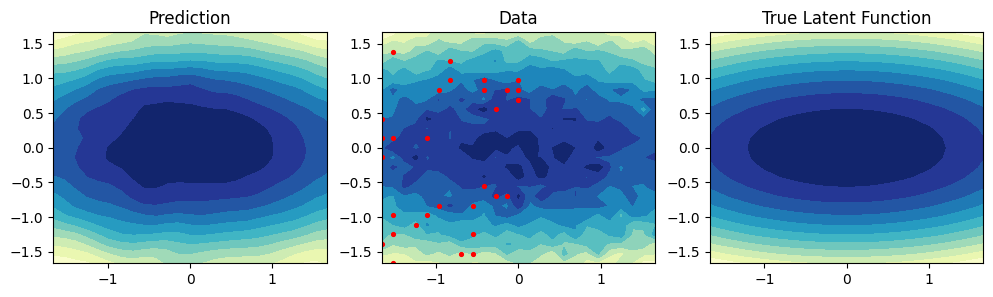

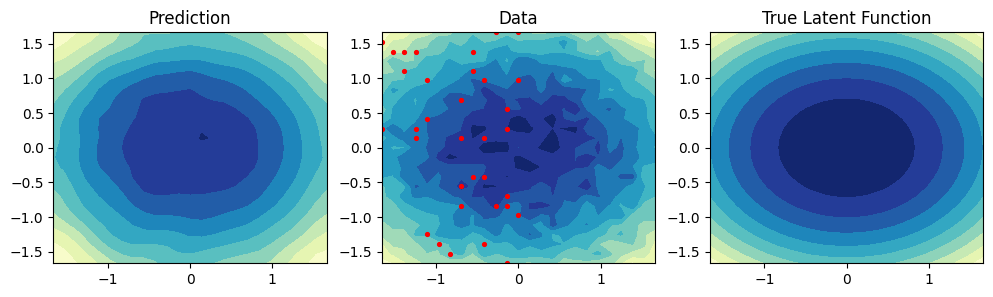

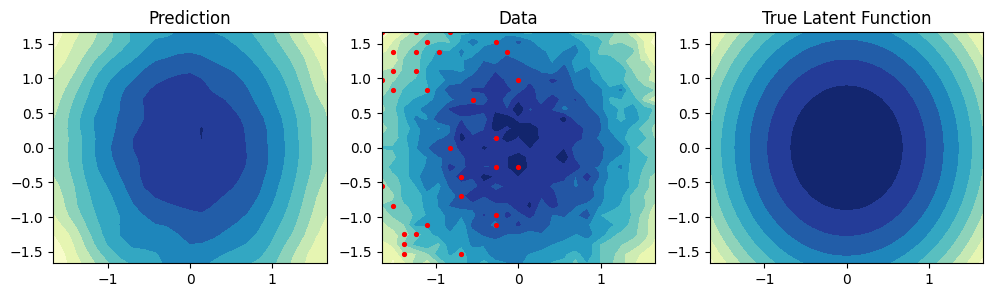

In [28]:
plot_robust_func('m_pred')

Mean Absolute Difference (Data - No Outliers) :  101.3565444946289
Mean Absolute Difference (Prediction) :  235.47401428222656
Mean Absolute Difference (Data - No Outliers) :  97.08243560791016
Mean Absolute Difference (Prediction) :  133.9264373779297
Mean Absolute Difference (Data - No Outliers) :  98.51832580566406
Mean Absolute Difference (Prediction) :  88.66148376464844
Mean Absolute Difference (Data - No Outliers) :  100.95301818847656
Mean Absolute Difference (Prediction) :  137.06961059570312
Mean Absolute Difference (Data - No Outliers) :  93.23451232910156
Mean Absolute Difference (Prediction) :  93.50685119628906
Mean Absolute Difference (Data - No Outliers) :  97.20365142822266
Mean Absolute Difference (Prediction) :  122.85631561279297
Mean Absolute Difference (Data - No Outliers) :  100.76924896240234
Mean Absolute Difference (Prediction) :  75.70191955566406
Mean Absolute Difference (Data - No Outliers) :  98.46554565429688
Mean Absolute Difference (Prediction) :  75.37

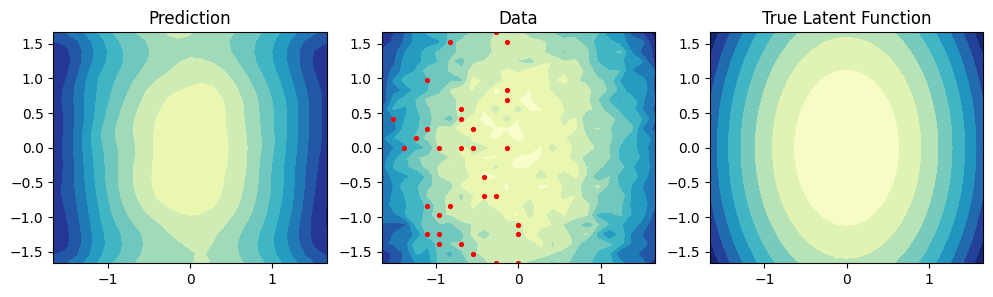

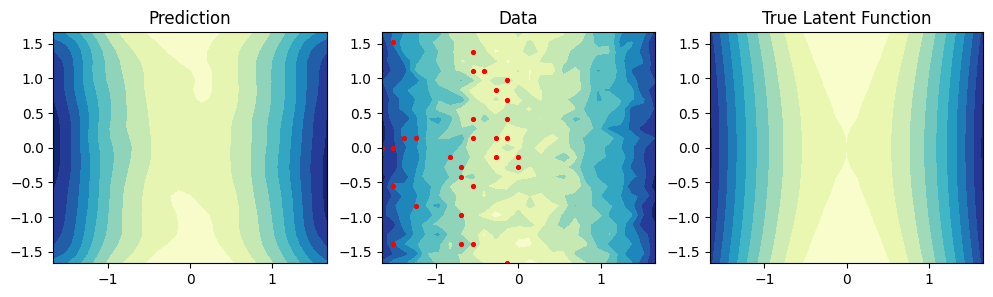

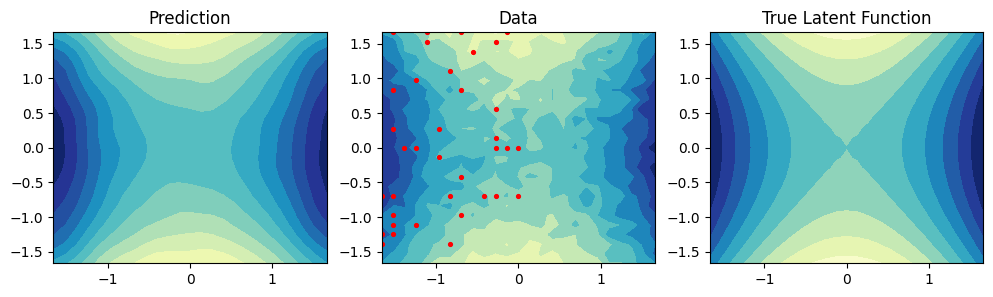

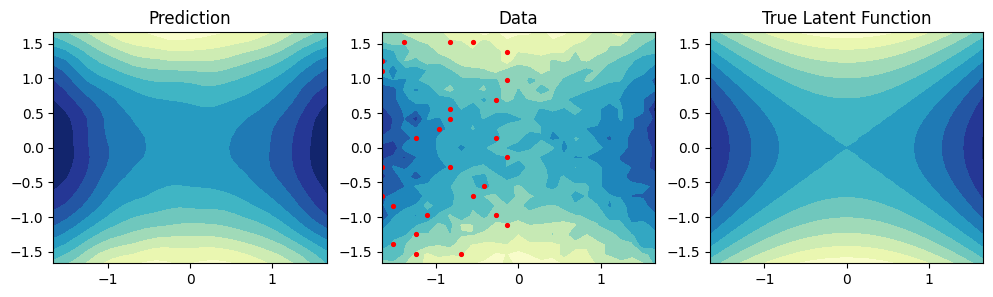

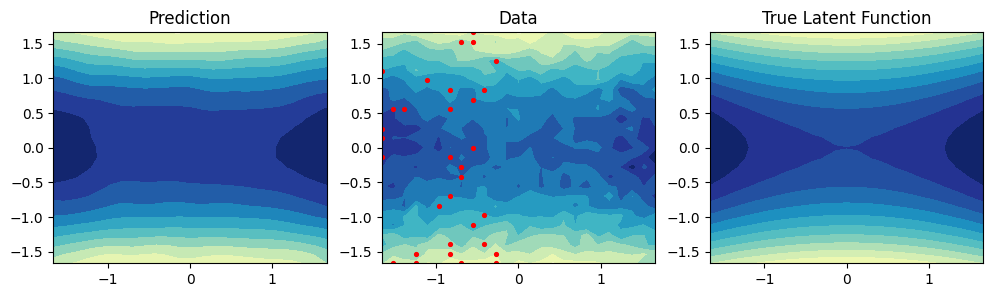

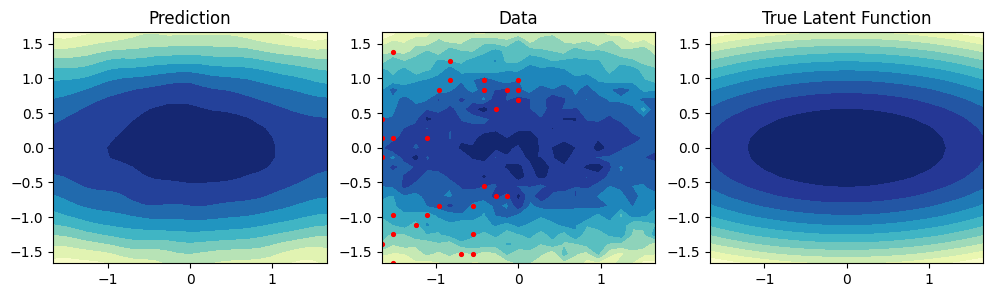

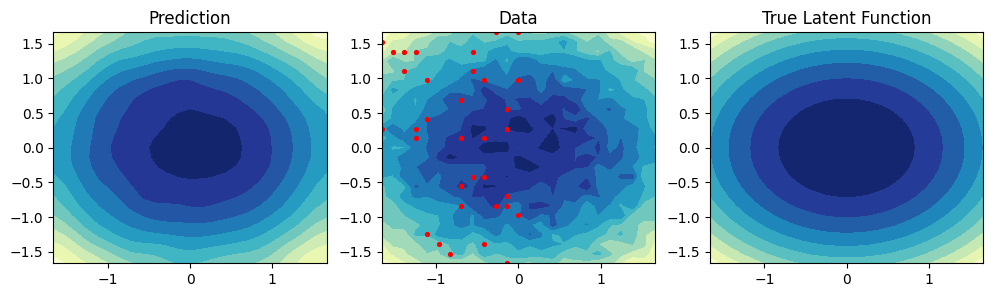

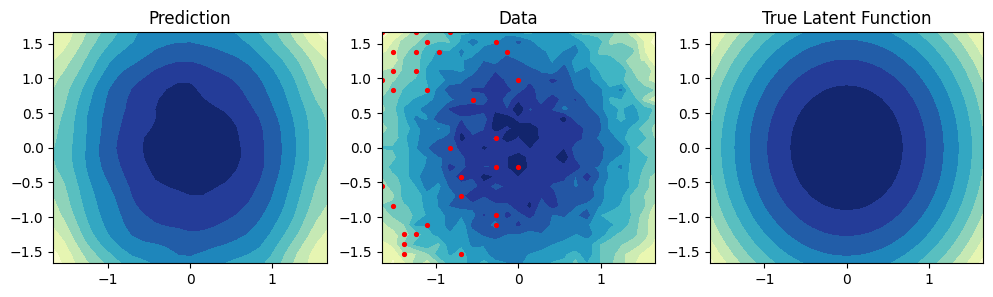

In [14]:
plot_robust_func('spatial')